# Identificação de vórtices

Neste notebook são criados dados fictícios e analisados os contornos, seguindo o seguinte algoritmo:

* Identificação dos possíveis contornos de vórtice:
    1. Identificação dos contornos que possuem somatório de [*Winding-Angles*](https://newtonexcelbach.com/2014/03/01/the-angle-between-two-vectors-python-version/) maior do que 2$\pi$ 
    2. Descarte dos contornos abertos
* Identificação dos contornos externos:
    1. Criação das matrizes de todas as combinações possíveis de contornos:
        * Contém
        * Está contido
    2. Identificação de quais contornos não contém nenhum outro (mínimos)
    3. Desconsideração de quaisquer contorno que contenha mais de um mínimo
    4. Identificação de quais contornos não estão contidos em nenhum outro (externos)
    
 
 Os ângulos e o algoritmo foi adaptado de ([Chaigneau et. al, 2008](https://www.sciencedirect.com/science/article/pii/S0079661108001663)):
 
 ![Winding-Angles](img/winding_angles.png)

## Importando pacotes

In [15]:
import itertools

import numpy as np
import numpy.linalg as la
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.mlab import bivariate_normal
import matplotlib._cntr as cntr
import seaborn as sns

## Definição das funções

### Identificação dos possíveis contornos de vórtice

In [16]:

 
def windingAngle(v1, v2):
    cosang = np.dot(v1, v2)
    sinang = la.norm(np.cross(v1, v2))
    
    return np.arctan2(sinang, cosang)

def isEddy(seg,threshold=2*np.pi,onlyclosed=True):
    x,y = seg.T
    
    dx,dy = np.diff(x),np.diff(y)
    
    try:
        angles = []
        for first,second in zip(range(0,len(dx)-1),range(1,len(dx))):
            angles.append(windingAngle([dx[second],dy[second]],[dx[first],dy[first]]))
        
        if sum(angles)>=threshold:
            out = True
        else:
            out = False
            
        if onlyclosed:
            if not(all(seg[-1]==seg[0])):
                out = False
    except:
        out = False
    
    return out

### Identificação dos contornos externos

In [17]:
def extLines(segs):
    
    ind = range(0,len(segs))

    # Para cada contorno, verificar quais este contém
    contem = []
    for i in ind:
        c = []
        for ic in ind:
            try:
                c.append(Path(segs[i]).contains_path(Path(segs[ic])))
            except:
                c.append(False)

        contem.append(c)

    contem = np.vstack(contem)
    # Para cada contorno, verificar quais este está contido
    estacontido = contem.T

    # Encontrando aqueles que não contem nada
    minimos = (contem.sum(1)==0)
    # Encontrando aqueles que não contem mais do que um dos que não contem nada
    multiplosminimos = contem[:,minimos].sum(1)>1

    # Considerando apenas os contornos que não contem mais de um dos que não contem nada
    estacontido = estacontido[~multiplosminimos,:][:,~multiplosminimos]

    # Inicia array como uma lista de Falses para todos os contornos
    isext = np.array([False]*len(segs))
    # Considerando apenas os que não estão contidos em nenhum outro contorno
    isext[~multiplosminimos] = (estacontido.sum(1)==0)
            
    return isext
        

## Criando matriz de dados aleatória

Nesta seção são somadas `n` gaussianas aleatórias dentro do campo.

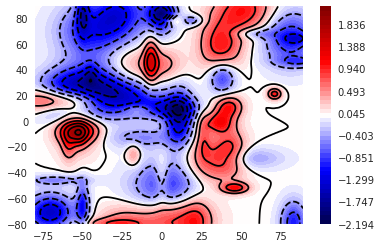

In [480]:
# Definindo alguns parâmetros
amp = 4
# Criando grid
X,Y = np.meshgrid(*([range(-80,90)]*2))

# Adicionando algumas oscilações como o somatório de várias gaussianas
n = 70
i,j = X.ravel()[np.random.randint(0,X.size,n)],Y.ravel()[np.random.randint(0,Y.size,n)]
Z = np.zeros_like(X)
for ii,jj in zip(i,j):
    Zp = bivariate_normal(X,Y,np.random.randint(1,6)*3,
                          np.random.randint(1,6)*3,
                            ii,jj)
    Zp = Zp/np.abs(Zp).max()
    Z = Z+Zp*0.5*np.random.randint(-2,3)


sns.set()
vmax = np.abs(Z).max()
levels = np.linspace(-vmax,vmax,50)
# Apresentando o dado
fig,ax = plt.subplots()
ct = ax.contourf(X,Y,Z,levels,vmin=-vmax,vmax=vmax,cmap='seismic')
ax.contour(X,Y,Z,10,colors='k')
fig.colorbar(ct)


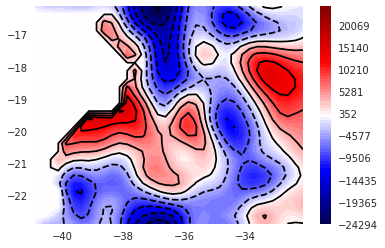

In [34]:
import scipy.io as sio

mat = sio.loadmat('/home/iury/Downloads/pickle_paraguay.mat')

X,Y,Z = mat['LON'],mat['LAT'],mat['PSI']

vmax = np.abs(Z).max()
levels = np.linspace(-vmax,vmax,50)

sns.set()
vmax = np.abs(Z).max()
levels = np.linspace(-vmax,vmax,70)
# Apresentando o dado
fig,ax = plt.subplots()
ct = ax.contourf(X,Y,Z,levels,vmin=-vmax,vmax=vmax,cmap='seismic')
ax.contour(X,Y,Z,10,colors='k')
fig.colorbar(ct)

## Análise

Nesta seção são analisados os dados seguindo as etapas:

1. Cálculo dos contornos
2. Identificação dos possíveis contornos de vórtice
3. Identificação dos contornos externos dos vórtices


### Cálculo dos contornos

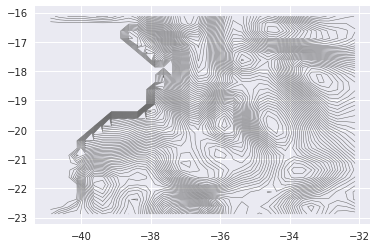

In [35]:
c = cntr.Cntr(X, Y, Z)

segs = []
for lvl in levels:
    trace = c.trace(lvl,lvl,0)
    [segs.append(seg) for seg in trace[:len(trace)//2]]


plt.figure()
for seg in segs:
    plt.plot(*seg.T,linewidth=0.5,color='0.4')

### Identificação dos possíveis contornos de vórtice

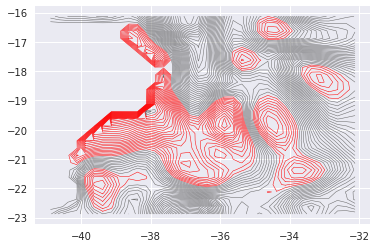

In [36]:
whichsegs = [isEddy(seg,1.5*np.pi) for seg in segs]

plt.figure()
for which,seg in zip(whichsegs,segs):
    if which:
        kw = dict(linewidth=0.5,color='r')
    else:
        kw = dict(linewidth=0.5,color='0.4')
    plt.plot(*seg.T,**kw)

### Identificação dos contornos externos dos possíveis vórtices

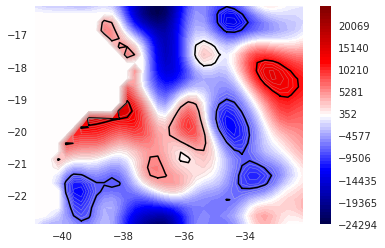

In [37]:
eddysegs = np.array(segs)[whichsegs]

isext = extLines(eddysegs)

fig,ax = plt.subplots()
ct = ax.contourf(X,Y,Z,levels,vmin=-vmax,vmax=vmax,cmap='seismic')
fig.colorbar(ct)

for ext,seg in zip(isext,eddysegs):
    if ext:
        kw = dict(linewidth=1.5,color='k')
    else:
        kw = dict(linewidth=0.5,color='0.8',alpha=0.5)
    ax.plot(*seg.T,**kw)